In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.functional import F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline
plt.ion()

In [4]:
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/Images/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                       data_transforms[x])
                for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle = True, num_workers=4)
              for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

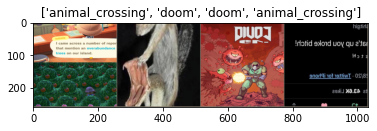

In [5]:
def imshow(inp, title = None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
torch.cuda.is_available()

True

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    results = {"train": {"loss" : [], "acc": []},\
               "val": {"loss" : [], "acc": []}}
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            results[phase]["loss"].append(epoch_loss)
            results[phase]["acc"].append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

In [44]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=16,
                               kernel_size=3,
                               stride = 1,
                               padding=0)
        
        self.conv2 = nn.Conv2d(in_channels=16, 
                               out_channels=32,
                               kernel_size=3,
                               stride = 1,
                               padding=0)
        
        
        self.fc = nn.Linear(32 * 62 * 62, 2)
        
    def forward(self, x):
        
        out = F.max_pool2d(self.conv1(x), kernel_size = 2)
        
        out = F.max_pool2d(F.relu(self.conv2(out)), kernel_size = 2)
        
        out = out.view(out.size(0), -1)
        
        return(F.softmax(self.fc(out), dim=0))
        

In [45]:
model_conv = CNN()

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [46]:
model_conv, model_results = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6535 Acc: 0.6024
val Loss: 0.7126 Acc: 0.5342

Epoch 1/24
----------
train Loss: 0.6844 Acc: 0.5174
val Loss: 0.6894 Acc: 0.4907

Epoch 2/24
----------
train Loss: 0.6747 Acc: 0.5731
val Loss: 0.6452 Acc: 0.6211

Epoch 3/24
----------
train Loss: 0.6478 Acc: 0.6421
val Loss: 0.6396 Acc: 0.6273

Epoch 4/24
----------
train Loss: 0.6417 Acc: 0.6386
val Loss: 0.6284 Acc: 0.6087

Epoch 5/24
----------
train Loss: 0.6338 Acc: 0.6462
val Loss: 0.6239 Acc: 0.6335

Epoch 6/24
----------
train Loss: 0.6275 Acc: 0.6476
val Loss: 0.6665 Acc: 0.6211

Epoch 7/24
----------
train Loss: 0.6497 Acc: 0.6351
val Loss: 0.6718 Acc: 0.5652

Epoch 8/24
----------
train Loss: 0.6676 Acc: 0.6177
val Loss: 0.6756 Acc: 0.5963

Epoch 9/24
----------
train Loss: 0.6556 Acc: 0.6135
val Loss: 0.6640 Acc: 0.6398

Epoch 10/24
----------
train Loss: 0.6562 Acc: 0.6344
val Loss: 0.6460 Acc: 0.6646

Epoch 11/24
----------
train Loss: 0.6385 Acc: 0.6636
val Loss: 0.6439 Acc: 0.6708

Ep

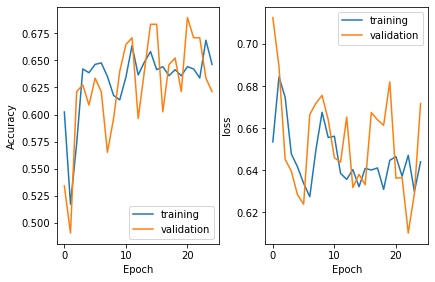

In [47]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.tight_layout(pad=1.5)

for i in range(2):
    if i == 0:
        val = "acc"
    else:
        val = "loss"
    axs[i].plot(model_results["train"][val], label='training')
    axs[i].plot(model_results["val"][val], label = "validation")

axs[0].set(xlabel='Epoch',ylabel='Accuracy')
axs[1].set(xlabel='Epoch',ylabel='loss')
axs[0].legend()
axs[1].legend()

plt.savefig('2conv1FC.png', dpi = 300)